As usual, dont wanna try out weaviate, let's do everything locally.
- Multimodal embedding model >  open_clip 'ViT-B-32'
- LMM model > Qwen2.5-VL-7B-Instruct

In [1]:
import open_clip
from datasets import load_dataset
from tqdm import tqdm
import torch
import numpy as np
from chromadb import Client
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info
from PIL import Image

/home/zhiyong/.pyenv/versions/3.10.4/envs/multimodal_rag/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
model.eval()  # model in train mode by default, impacts some models with BatchNorm or stochastic depth active
tokenizer = open_clip.get_tokenizer('ViT-B-32')

In [3]:
from torch.utils.data import DataLoader
dataset = load_dataset('nlphuji/flickr30k')

# Have to load each image individually, no batching
processed_images = []
captions_tokens = []
for sample in tqdm(dataset['test']):
    processed_images.append(preprocess(sample['image']).unsqueeze(0))
    captions_tokens.append(tokenizer(sample['caption']))

100%|██████████| 31014/31014 [02:33<00:00, 201.67it/s]


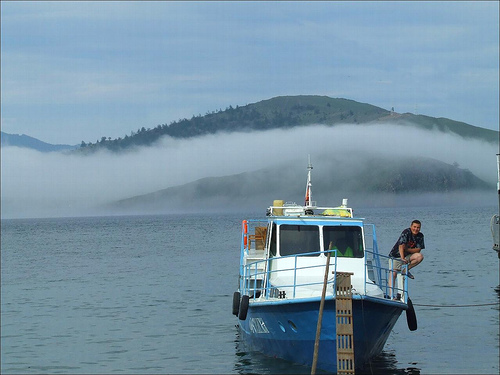

In [46]:
Image.fromarray(np.array(sample['image']))

In [4]:
from torch.utils.data import DataLoader
dataset = load_dataset('nlphuji/flickr30k')

image_ids = []
processed_images = []
image_nps = []

caption_ids = []
captions_tokens = []
captions = []

for i, sample in enumerate(tqdm(dataset['test'])):
    image_ids.append(str(i))
    processed_images.append(preprocess(sample['image']).unsqueeze(0))
    image_nps.append(np.array(sample['image']))

    # captions are nested
    for caption_index, caption in enumerate(sample['caption']):
        caption_ids.append(f'{i}_caption_batch_{caption_index}')
        captions_tokens.append(tokenizer(caption))
        captions.append(caption)
    
    # prevent oom
    if i == 20000:
        break

 64%|██████▍   | 20000/31014 [01:54<01:03, 174.54it/s]


In [5]:
# Batch and convert into embeddings
batch_size = 128
image_embeddings = []
text_embeddings = []
with torch.no_grad(), torch.cuda.amp.autocast():
    for i in tqdm(range(0, len(processed_images), batch_size)):
        image_batch = processed_images[i:i+batch_size]
        image_batch = torch.stack(image_batch).squeeze()
        _image_embeddings = model.encode_image(image_batch)
        _image_embeddings /= _image_embeddings.norm(dim=-1, keepdim=True)
        image_embeddings.append(_image_embeddings)

# Captions are already nested. Preserve this nested structure so the indexes can be maintained between text and image embeddings
with torch.no_grad(), torch.cuda.amp.autocast():
    for i in tqdm(range(0, len(captions_tokens), batch_size)):
        caption_batch = captions_tokens[i:i+batch_size]
        caption_batch = torch.stack(caption_batch).squeeze()
        # caption_batch = torch.stack(caption_batch).squeeze()
        _text_embeddings = model.encode_text(caption_batch)
        _text_embeddings /= _text_embeddings.norm(dim=-1, keepdim=True)
        text_embeddings.append(_text_embeddings)

/tmp/ipykernel_23299/3379997733.py:5: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():
100%|██████████| 157/157 [07:40<00:00,  2.93s/it]
/tmp/ipykernel_23299/3379997733.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():
100%|██████████| 782/782 [28:28<00:00,  2.18s/it]


In [6]:
# ok as expected, now to store the embeddings into chroma
image_embeddings[0].shape, text_embeddings[0].shape

(torch.Size([512, 512]), torch.Size([512, 512]))

In [13]:
np.array(torch.cat(image_embeddings, dim=0)).shape

/tmp/ipykernel_1473/628640643.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  np.array(torch.cat(image_embeddings, dim=0)).shape


(20001, 512)

In [6]:
# Convert list of tensor to np array for loading into chroma
np_image_embeddings = np.array(torch.cat(image_embeddings, dim=0))
np_text_embeddings = np.array(torch.cat(text_embeddings, dim=0))

/tmp/ipykernel_23299/3662949841.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  np_image_embeddings = np.array(torch.cat(image_embeddings, dim=0))
/tmp/ipykernel_23299/3662949841.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  np_text_embeddings = np.array(torch.cat(text_embeddings, dim=0))


In [13]:
client.delete_collection(name="flickr30k")

In [ ]:
# Load everything into chroma
client = Client()
collection = client.create_collection("flickr30k")
# image_ids = [f'id_{i}' for i in range(len(np_image_embeddings))]
# images = dataset['test']['image']

# flattened = [(embedding, f'id_{i}_caption_{inner_i}') for i, sublist in enumerate(np_text_embeddings) for inner_i, embedding in enumerate(sublist)]
# caption_embeddings = [j[0] for j in flattened]
# caption_ids = [j[1] for j in flattened]
# flattened_captions = [caption for sublist in dataset['test']['caption'] for caption in sublist]

vector_load_batch_size = 128

for i in tqdm(range(0, len(image_ids), vector_load_batch_size)):
    image_id_batch = image_ids[i:i+vector_load_batch_size]
    image_embedding_batch = np_image_embeddings[i:i+vector_load_batch_size]
    # image_np_batch =  image_nps[i:i+vector_load_batch_size] # [a.tolist() for a in image_nps[i:i+vector_load_batch_size]]
    collection.add(ids=image_id_batch, embeddings=image_embedding_batch)#, metadatas=[{'image': image} for image in image_np_batch])

for i in tqdm(range(0, len(caption_ids), vector_load_batch_size)):
    captions_batch = captions[i:i+vector_load_batch_size]
    caption_id_batch = caption_ids[i:i+vector_load_batch_size]
    caption_embedding_batch = np_text_embeddings[i:i+vector_load_batch_size]
    collection.add(ids=caption_id_batch, embeddings=caption_embedding_batch, metadatas=[{'captions': caption} for caption in captions_batch])

  0%|          | 0/157 [00:00<?, ?it/s]


ValueError: Expected metadata value to be a str, int, float or bool, got [[[  0   6   4]
  [  2   6   5]
  [  3   5   4]
  ...
  [219 244 249]
  [222 253 255]
  [221 249 250]]

 [[  4   8   7]
  [  3   5   4]
  [  5   7   6]
  ...
  [228 253 250]
  [212 245 254]
  [218 253 255]]

 [[  3   3   3]
  [  4   4   4]
  [  5   5   5]
  ...
  [242 255 255]
  [232 255 251]
  [214 245 250]]

 ...

 [[166 177 147]
  [180 188 131]
  [130 155 100]
  ...
  [106 158  86]
  [134 172 113]
  [107 163  72]]

 [[202 219 151]
  [144 175 115]
  [133 160 117]
  ...
  [157 188 129]
  [156 186 124]
  [157 196 117]]

 [[144 157  87]
  [185 211 172]
  [184 214 152]
  ...
  [156 186 122]
  [191 200 153]
  [106 126  65]]] which is a ndarray in add.

In [ ]:
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-7B-Instruct",
    torch_dtype=torch.bfloat16,
    attn_implementation="flash_attention_2",
    device_map="auto",
)

# default processer
processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-7B-Instruct")

# The default range for the number of visual tokens per image in the model is 4-16384.
# You can set min_pixels and max_pixels according to your needs, such as a token range of 256-1280, to balance performance and cost.
# min_pixels = 256*28*28
# max_pixels = 1280*28*28
# processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-7B-Instruct", min_pixels=min_pixels, max_pixels=max_pixels)

messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen-VL/assets/demo.jpeg",
            },
            {"type": "text", "text": "Describe this image."},
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)